# Class-averaging simulation for SNR and Precision behavior

## Goal
To test out the ultimate limit of our class-averaging approach for precision enhancement

1. WSe2 multislice images without noise, crop it into 64 x 64 or like 100 x 100
2. Apply Poisson noise or other types of noise

## 00. Import packages and define functions

In [1]:
from tqdm.auto import tqdm, trange
import numpy as np
import matplotlib.pyplot as plt
from tifffile import imsave, imread
import os
from scipy import optimize
import time
import pickle
from scipy.ndimage import gaussian_filter
import imageio

In [2]:
# Defining functions
def gaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

def guassian_fit(image,positions,lbox):
    #Fitting will fail horribly in a noisy image, return the original position if the fitting result is beyond the outerspace
    new_pos = []
    for atom in positions:
        data=image[atom[0]-lbox+1:atom[0]+lbox,atom[1]-lbox+1:atom[1]+lbox]
        data = data-data.min()
        params = fitgaussian(data)
        
        
        if abs(params[1]-lbox)>lbox or abs(params[2]-lbox)>lbox: #If the fitted result is out of the designed 7*7 window
            pos = [atom[0]-lbox+1, atom[1]-lbox+1]
        else:
            pos = [params[1]-lbox+atom[0]+1,params[2]-lbox+atom[1]+1]
            
        new_pos.append(pos)
        #show_fitting(data)
        
    return np.array(new_pos)

def show_fitting(data):
    plt.matshow(data, cmap='gray')
    #plt.matshow(data, cmap=plt.cm.gist_earth_r)
    params = fitgaussian(data)
    fit = gaussian(*params)

    plt.contour(fit(*np.indices(data.shape)), cmap=plt.cm.copper)
    ax = plt.gca()
    (height, x, y, width_x, width_y) = params

    plt.text(0.95, 0.05, """
    x : %.3f
    y : %.3f
    width_x : %.1f
    width_y : %.1f""" %(x, y, width_x, width_y),
            fontsize=16, horizontalalignment='right',
            verticalalignment='bottom', transform=ax.transAxes)
    
    plt.show()

## 01. Import image and crop it 

### 01.01 Multislice image and Exp image

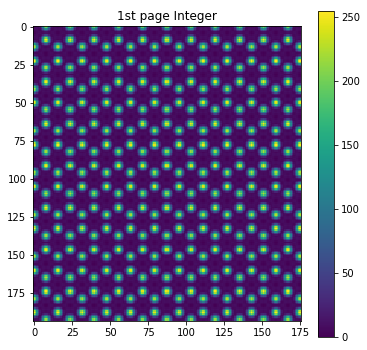

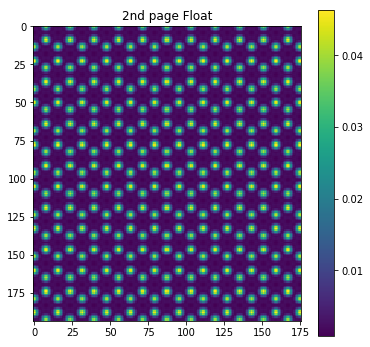

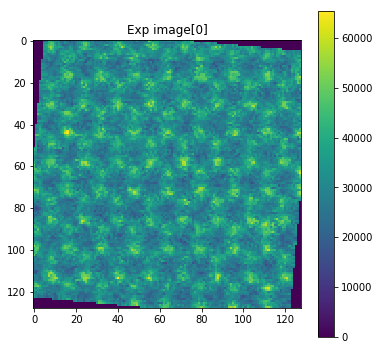

In [3]:
img = imageio.mimread('Inputs//Multislice_WSe2_2074pm_2K.tif')
Exp_img_stack = np.array(imageio.mimread('Inputs//Exp_aligned_stack_06_Regular_1470.tif'))

px_size = 20.74 #pm

figsize=(6,6)
plt.figure(figsize=figsize)
plt.title('1st page Integer')
plt.imshow(img[0])
plt.colorbar()
plt.show()

plt.figure(figsize=figsize)
plt.title('2nd page Float')
plt.imshow(img[1])
plt.colorbar()
plt.show()

plt.figure(figsize=figsize)
plt.title('Exp image[0]')
plt.imshow(Exp_img_stack[0])
plt.colorbar()
plt.show()

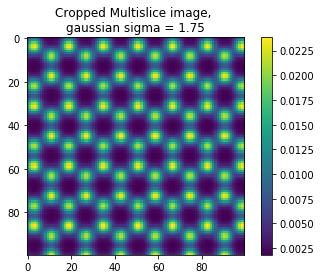

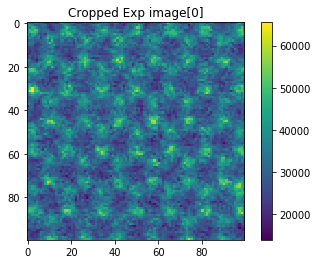

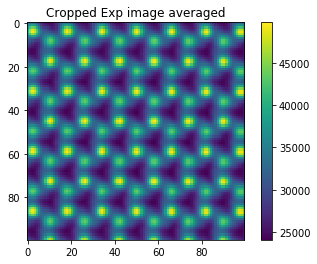

In [4]:
sigma=1.75 #This gaussian bluring is optional, unit = pixel
center = [83,87] #20.74pm
width = 100 #unit = pixel

img_crop = gaussian_filter(img[1],sigma=sigma)[center[0]-width//2:center[0]+width//2,
                  center[1]-width//2:center[1]+width//2]

plt.figure()
plt.title('Cropped Multislice image, \ngaussian sigma = %s'%(sigma))
plt.imshow(img_crop)
plt.colorbar()
plt.show()

Exp_center = [63,64]
Exp_img_stack_crop = Exp_img_stack[:, Exp_center[0]-width//2:Exp_center[0]+width//2,
                  Exp_center[1]-width//2:Exp_center[1]+width//2]

plt.figure()
plt.title('Cropped Exp image[0]')
plt.imshow(Exp_img_stack_crop[0])
plt.colorbar()
plt.show()

Exp_img_avg = np.mean(Exp_img_stack_crop, axis=0)

plt.figure()
plt.title('Cropped Exp image averaged')
plt.imshow(Exp_img_avg)
plt.colorbar()
plt.show()

### 01.02 Define the Peak/Noise mask and calculate the SNR_perfect

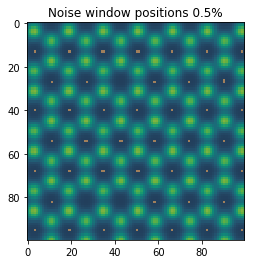

Sum(Noise_center_mask) = 50
Selected px ratio =  0.005


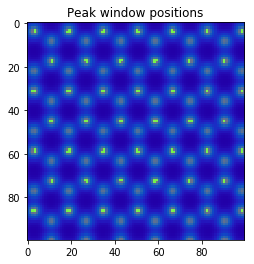

Sum(Peak_center_mask) =  100
Selected px ratio =  0.01


In [5]:
#Automatically generating the threshold value for assigned ratio
noise_percent = 0.5 #unit percent
thr_noise = np.percentile(np.ravel(img_crop),noise_percent)
Noise_center_mask = (img_crop<=thr_noise)

plt.figure()
plt.title('Noise window positions 0.5%')
plt.imshow(img_crop)
plt.imshow(Noise_center_mask, alpha=0.5, cmap='summer')
plt.show()

print('Sum(Noise_center_mask) =',np.sum(Noise_center_mask))
print('Selected px ratio = ',np.sum(Noise_center_mask)/np.shape(Noise_center_mask)[0]**2)

#Automatically generating the threshold value for assigned ratio
peak_percent = 99 #unit percent
thr_peak = np.percentile(np.ravel(img_crop),peak_percent)
Peak_center_mask = (img_crop>=thr_peak)

plt.figure()
plt.title('Peak window positions')
plt.imshow(img_crop)
plt.imshow(Peak_center_mask, alpha=0.5, cmap='winter')
plt.show()

print('Sum(Peak_center_mask) = ',np.sum(Peak_center_mask))
print('Selected px ratio = ',np.sum(Peak_center_mask)/np.shape(Peak_center_mask)[0]**2)

In [6]:
def SNR_calc(input_img):
    """
    Note: If you want to do background subtraction, don't subtract np.min(input_img) 
    Since the minumum value for high/low SNR images will be quite different
    For example it can be 11800 vs 24639.75 for raw and averaged. 
    In other words, you should subtract a common value, or sth like np.mean(input_img[Noise_center_mask]) that are similar.
    However that might cause negative values during the process, even though that won't affect the results.
    
    Considering divide the range to normalize the input?
    """
    Dynamic_range = np.mean(input_img[Peak_center_mask]) - np.mean(input_img[Noise_center_mask])
    SNR_Direct = Dynamic_range/np.std(input_img[Noise_center_mask])
    return(SNR_Direct)

print('Size of noise window = ',np.count_nonzero(Noise_center_mask))
print('Peak = ', np.mean(img_crop[Peak_center_mask]))
print('Noise = ',np.std(img_crop[Noise_center_mask]))
print('SNR_perfect = ', SNR_calc(img_crop))
print('Note: With this SNR definition, the perfect SNR is NOT infinite because the selected background is not truly uniform')
print('Also note that, the signal/noise will both be amplified by multiplication, but only signal will be affected by add/subtract')

Size of noise window =  50
Peak =  0.023278603
Noise =  6.6584835e-06
SNR_perfect =  3219.3723
Note: With this SNR definition, the perfect SNR is NOT infinite because the selected background is not truly uniform
Also note that, the signal/noise will both be amplified by multiplication, but only signal will be affected by add/subtract


## 02. Apply/add noise with given dose level

In [153]:
#Fundamental const
charge = 1.609*10**-19 #Coulomb per e- 

#Exp setup
dwell = 2*10**-6 #sec
prob = 1 #Scattering probability
probe_current = (15*10**-12)/charge #e-/sec
Offset = -2.400#-1.440161133 #Offset current
G_pmt = 68.637384 #PMT Gain

#Detector constant
f_adu = 16967 #Conversion facctor for ADC, current -> ADU
K = 1.878574 #Preset offset current
dark_current = 2.029*10**5 #e-/sec
eta = 10**2 #e- -> effective hv
epsilon = 2.217*10**7 #hv -> effective photoelectron


In [155]:
dark_current

202900.0

In [156]:
probe_current

93225605.96643879

In [157]:
e_signal

186.85701193287755

In [158]:
photon_signal

18685.701193287754

In [154]:
e_signal = (prob*probe_current+dark_current)*dwell #e- number
photon_signal = e_signal*eta # hv number
pe_current = np.random.poisson(photon_signal, size=1000)*(epsilon*charge/dwell) #photoelectron current (Coloumb/sec)
Out_current = pe_current*G_pmt + Offset + K #(Amp)
ADU = Out_current * f_adu

print('min = ', np.min(ADU))
print('mean = ', np.mean(ADU))
print('max = ', np.max(ADU))
print('std = ', np.std(ADU))

min =  29176.36802426318
mean =  29973.586223907576
max =  31162.0761656238
std =  277.8628349130063


In [ ]:
### Set up STEM simulation parameter
dwell = 20/1000 #micro sec 20
current = 30 #pA 30
charge_constant = 1.6*10**-19 #Coulomb 
dark_count_factor = 0 # Originally 2 
Stobbs = 260 #Testing Stobbs  

Scaling_factor = (dwell*10**-6*current*10**-12)/charge_constant
dose = Scaling_factor/(px_size/100)**2
print('Scaling factor = ',Scaling_factor,'e-/px')
print('Dose = ',dose,'e-/Ang^2')
print("\nNote: This dose does not include fly-back time hence it's slightly underestimating")

dark_count = dark_count_factor*(np.max(img_crop)-np.min(img_crop))*Scaling_factor
print('Dark_count factor= ',dark_count_factor)
print('Dark_count = ',dark_count)


ideal_img = Stobbs*img_crop*Scaling_factor + dark_count
plt.figure()
plt.title('Ideal image + dark count (e-)')
plt.imshow(ideal_img)
plt.colorbar()
plt.show()
print('Px max = ', np.max(ideal_img))
print('Px min = ', np.min(ideal_img))
print('SNR ideal img = ', SNR_calc(ideal_img))

#print('\nSelected bkg px = ', ideal_img[Noise_center_mask])
print('\nSelected bkg px value max = ', np.max(ideal_img[Noise_center_mask]), 'e-')
print('Selected bkg px value min = ', np.min(ideal_img[Noise_center_mask]), 'e-')
print('Mean of selected bkg px = ', np.mean(ideal_img[Noise_center_mask]), 'e-')
print('\nStd of selected bkg px = ', np.std(ideal_img[Noise_center_mask]), 'e-')
print('Expected Poisson std = ', np.sqrt(np.mean(ideal_img[Noise_center_mask])), 'e-')
print('Inherent fluctuation/statistical fluctuation = ', np.std(ideal_img[Noise_center_mask])/np.sqrt(np.mean(ideal_img[Noise_center_mask]))*100, '%')
print('Note: The inherent fluctuation came from the non-uniform window, \nwhile the statistical fluctuation originate from the pixel value.')
print('The larger the ratio, the more significant the non-uniform window is (less ideal).')

### 02.01 Add noise

In [ ]:
#%%time

iterations = 1000 #Number of noisy images
save_noisy = False
noise_type='Poisson'
extra_noise = False

ideal_img_ravel = np.ravel(ideal_img)
noise_array=np.zeros((len(ideal_img_ravel), iterations), dtype='uint32')

if noise_type=='Poisson':
    desc='Making ' + str(iterations) + ' noisy images'
    for i in tqdm(range(len(ideal_img_ravel)), desc=desc):
        #Walk through pixel by pixel to apply Poisson noise
        #The poisson param can be float, but the output will always be integer.
        #Assigning to int32 is just to save time and disk space
        noise_array[i,:] = np.int32(np.random.poisson(ideal_img_ravel[i], iterations))
        img_noisy_stack = np.rollaxis(np.reshape(noise_array,(width,width,iterations)),2,0)
    img_noisy_stack += np.random.poisson(Stobbs*1, np.shape(img_noisy_stack)).astype('uint32')
elif noise_type=='Random':
    rand=50
    noise_array = np.tile(ideal_img_ravel,(iterations,1)).T + np.int32(np.random.randint(low=-rand,high=rand,size=(len(ideal_img_ravel),iterations)))
    img_noisy_stack = np.rollaxis(np.reshape(noise_array,(width,width,iterations)),2,0)

elif noise_type=='Gaussian':
    noise_array = np.tile(ideal_img_ravel,(iterations,1)).T + np.int32(np.random.normal(loc=0,scale=50,size=(len(ideal_img_ravel),iterations)))
    img_noisy_stack = np.rollaxis(np.reshape(noise_array,(width,width,iterations)),2,0)

if extra_noise ==True:
    img_noisy_stack = np.int32(img_noisy_stack) + \
                      np.random.normal(loc=0, scale=50, size=(np.shape(img_noisy_stack))) + \
                      np.int32(np.random.randint(low=-50,high=50,size=(np.shape(img_noisy_stack))))
    

if save_noisy == True: 
    directory = 'Noisy_Stack//'
    if os.path.exists(directory)==False:
        os.mkdir(directory)
    #Saving the noisy image stack
    imsave(directory + 'Noisy_img_stack_dose_'+str(int(np.round(dose)))+'_iter_'+str(iterations)+'.tif', img_noisy_stack)
    print('Noisy_img_stack save as ', img_noisy_stack.dtype)

print("Simulating using %r noise" %noise_type )
plt.figure()
plt.title('Simulated noisy image')
plt.imshow(img_noisy_stack[0])
plt.colorbar()
plt.show()

plt.figure()
plt.title('Histogram of Simulated noisy image')
plt.hist(np.ravel(img_noisy_stack[0]))
plt.show()

### 02.02 Match with experiment images

In [ ]:
%%time

gain = 100 #Assuming gain*P(ax+b) + bias = experiment
bias = 0
modified_simu_stack = img_noisy_stack * gain + bias
#modified_simu_stack = gain*img_noisy_stack
#modified_simu_stack = (img_noisy_stack+np.random.poisson(bkg,(np.shape(img_noisy_stack)))) * gain
line_pos = width//2
line_prof_num = np.min((1000, len(Exp_img_stack_crop), len(modified_simu_stack)))

plt.figure()
plt.title('Noisy multislice image')
plt.axvline(line_pos, linewidth=1, color='r')
plt.imshow(modified_simu_stack[0])
plt.colorbar()
plt.show()

plt.figure()
plt.title('Exp image')
plt.axvline(line_pos, linewidth=1, color='r')
plt.imshow(Exp_img_stack_crop[0])
plt.colorbar()
plt.show()

plt.figure()
plt.title('Noisy images')
for i in trange(line_prof_num, desc='Plotting line profiles overlay'):
    plt.plot(modified_simu_stack[i,:,int(line_pos)], color='C0', alpha=0.2)
    plt.plot(Exp_img_stack_crop[i,:,int(line_pos)], color='C1', alpha=0.05)
plt.show()

plt.figure()
plt.title('Averaged images')
plt.plot(np.mean(modified_simu_stack, axis=0)[:,int(line_pos)], 
         label ='Noisy Simulation avg. from %s frames' %len(modified_simu_stack))
plt.plot(np.mean(Exp_img_stack_crop, axis=0)[:,int(line_pos)], 
         label='Exp avg. from %s frames' %len(Exp_img_stack_crop))
plt.legend(loc=4)
plt.show()

Simu_bkg_std_array = np.zeros_like(modified_simu_stack)
for i, modified_simu in enumerate(modified_simu_stack):
    Simu_bkg_std_array[i] = np.std(modified_simu[Noise_center_mask])
print('Raw Simulation Bkg std =', np.mean(Simu_bkg_std_array))

### Make mask for exp images
Exp_thr_noise = np.percentile(np.ravel(Exp_img_avg), noise_percent)
Exp_Noise_center_mask = (Exp_img_avg<=Exp_thr_noise)

Exp_bkg_std_array = np.zeros(len(Exp_img_stack_crop))
for i, Exp_img_crop in enumerate(Exp_img_stack_crop):
    Exp_bkg_std_array[i] = np.std(Exp_img_crop[Exp_Noise_center_mask])
print('Raw Exp Bkg std =', np.mean(Exp_bkg_std_array))


### 02.02 SNR for each noisy image

In [ ]:
%%time

k=len(modified_simu_stack)//2 #Show every kth image, 5 for 20 percentile.
print('#Show every ', k, 'th image')

SNR_array = np.zeros(len(modified_simu_stack))
Mean_peak_array = np.zeros(len(modified_simu_stack))
for i in range(len(modified_simu_stack)):
    SNR_Direct = SNR_calc(modified_simu_stack[i])
    SNR_array[i] = SNR_Direct
    Mean_peak_array[i] = np.mean(modified_simu_stack[i][Peak_center_mask])
    
    if i%k==0:
        plt.figure()
        plt.title(str(i)+ 'th image')
        plt.imshow(modified_simu_stack[i])
        plt.colorbar()
        plt.show()
        print(str(i)+'th SNR = ', SNR_Direct)
        print('Px max = ', np.max(modified_simu_stack[i]))
        print('Px min = ', np.min(modified_simu_stack[i]))

SNR_raw_mean = np.sum(SNR_array[SNR_array<np.inf])/len(SNR_array[SNR_array<np.inf])
print('\nSNR raw mean = ', SNR_raw_mean)
print('SNR raw std. = ', np.std(SNR_array))

plt.figure()
plt.title('SNR Distribution')
plt.hist(SNR_array)
plt.show()

plt.figure()
plt.title('Signal for all simu raw')
plt.plot(Mean_peak_array)
plt.show()

### 02.03 SNR for summed image

In [ ]:
Sum_img = np.sum(modified_simu_stack, axis=0)/len(modified_simu_stack)

SNR_avg = SNR_calc(Sum_img)
print('Total SNR for summing',str(iterations),'image = ', SNR_avg)
print('SNR raw mean = ',SNR_raw_mean)
print('SNR gain = ',SNR_avg/SNR_raw_mean)
print('Effective dose =', '{:.2e}'.format(dose*iterations), 'e-/Ang^2')

plt.figure()
plt.title('Summed noisy simulated image')
plt.imshow(Sum_img)
plt.colorbar()
plt.show()
print('Px min = ', np.min(Sum_img))

modified_ideal_img = ideal_img*gain+bias
plt.figure()
plt.title('Modified ideal image')
plt.imshow(modified_ideal_img)
plt.colorbar()
plt.show()

print('Px min = ', np.min(modified_ideal_img))
print('Px max = ', np.max(modified_ideal_img))
print('Mean Peak window value = ', np.mean(modified_ideal_img[Peak_center_mask]))
print('SNR for modified ideal image = ', SNR_calc(modified_ideal_img))


Diff_img = (Sum_img - modified_ideal_img)
plt.figure()
plt.title('Difference image')
plt.imshow(Diff_img)
plt.colorbar()
plt.show()
RMSE = np.sqrt(np.sum(Diff_img**2))/np.shape(Diff_img)[0]**2
print('RMSE = ',RMSE)
print('Max Diff = ', np.max(np.abs(Diff_img)))

### 02.04 Making registered stages

In [ ]:
%%time

save_regiStage = False

RegisteredStages_stack=np.zeros_like(modified_simu_stack, dtype='float32')
RMSE_array = np.zeros(len(modified_simu_stack))
SNR_gain_array=np.zeros(len(modified_simu_stack))
Signal_regi_array = np.zeros(len(modified_simu_stack))
im_accum = np.zeros_like(modified_simu_stack[0])

for i, img in tqdm(enumerate(modified_simu_stack), desc='Making registered stages'):
    im_accum += img
    RegisteredStages = im_accum/float(i+1)
    RegisteredStages_stack[i] = RegisteredStages
    
    Diff_img = (RegisteredStages - modified_ideal_img)
    RMSE_array[i] = np.sqrt(np.sum(Diff_img**2))/np.shape(Diff_img)[0]**2
    SNR_gain_array[i] = SNR_calc(RegisteredStages)/SNR_raw_mean
    Signal_regi_array[i] = np.mean(RegisteredStages[Peak_center_mask])
    
if save_regiStage == True: 
    directory = 'RegisteredStages//'
    if os.path.exists(directory)==False:
        os.mkdir(directory)
    #Saving the noisy image stack
    output_fn = directory + 'RegisteredStages_dose_'+str(int(np.round(dose)))+'_iter_'+str(iterations)+'.tif'
    imsave(output_fn, RegisteredStages_stack)
    print('RegisteredStages save as ', RegisteredStages_stack.dtype)
    
#Plotting    

for idx in (np.linspace(0,len(RegisteredStages_stack)-1,5)):
    plt.figure()
    plt.title(str(int(idx+1)) + 'th image')
    plt.imshow(RegisteredStages_stack[int(idx)])
    plt.colorbar()
    plt.show()

plt.figure()
plt.title('Plot of Signal RegisteredStages')
plt.plot(Signal_regi_array)
plt.show()

### 02.05 Plotting SNR gain as increasing number of frames

### Work note 20200208

SNR_calc function has a non-necessary img background subtraction step (img = img - img.min), for low and high SNR images, this img.min can be very different and will affect the estimation of signal in the SNR calculation. A better way is either skip the background step, or do a full normalization (img = (img-img.min)/(img.max-img.min)), hence the SNR won't be affected by the background level.

For my SNR definition, the number of background pixels has quite significant effect. The background pixels are compared with each other to emulate the fluctuation within single px, hence there's no point to compare std from like 2 px. But also we will not want to include pixels with intensities are too high, the workaround is to use LARGER image, so that you increase the number of pixels but not increasing the ratio.

In the end, I noticed that as N(number of images)->very large, the bkg non-uniformity will get more and more significant since the statistical fluctuation become so small that we have to consider the hard limit of bkg non-uniformity on SNR gain. But this is just the limitation for my SNR definition, the RMSE has no issues with bkg non-uniformity.

In [ ]:
print('SNR_raw_mean = ',SNR_raw_mean)
print('Final SNR gain = ', SNR_gain_array[-1])
SNR_gain_calculated_limit = SNR_calc(img_crop)/SNR_raw_mean
print('Calculated SNR gain limit = ', SNR_gain_calculated_limit)
print("This limit exist because the chosen bkg wasn't uniform, and the effeect will become significant while statistical fluctuation become smaller")


plt.figure()
plt.title('Final SNR after summing '+ str(iterations) + ' images')
plt.plot(SNR_gain_array*SNR_raw_mean, label='Registeted Stages SNR')
plt.legend()
plt.show()

N = np.linspace(1,iterations,iterations)
plt.figure(figsize=(12,6))
plt.title('SNR gain (SD)')
plt.plot(np.array(SNR_gain_array), label='Simu SNR gain (SD)')
plt.plot(np.sqrt(N),label='sqrt(N)')
plt.plot(np.sqrt(SNR_gain_calculated_limit**2*N/(SNR_gain_calculated_limit**2+N)),label='$\sqrt{\\frac{N}{1+\\frac{N}{SNRlimit^2}}}$')
plt.legend(fontsize=18)
plt.show()

plt.figure()
plt.title('SNR gain (RMSE)')
plt.plot((RMSE_array[0]*np.array(RMSE_array)**-1), label='Simu SNR gain (RMSE)')
plt.plot(np.sqrt(N),label='sqrt(N)')
if noise_type=='Random':
    LIM=rand*2**0.5 #For random noise, LIM = Random_range/sqrt(2) can match the RMSE very well
    plt.plot(np.sqrt(N*LIM**2/(N+LIM**2)),label='$\sqrt{\\frac{N}{1+\\frac{N}{SNRlimit^2}}}$') #For added random noise
plt.legend()
plt.show()

### Special trial: Signal = gain*P(bkg)+bias, will it still scale with sqrt(N)?

__Well, sure things!__

In [ ]:
%%time
points=200
avg_iter = 50000
orig_poisson = np.random.poisson(172, size=(points,avg_iter))
print('orig std = ', np.std(orig_poisson[0]))
print('Std after averaging %s points = %s'%(avg_iter, np.std(np.mean(orig_poisson,axis=1))))
print('SNR_gain = ', np.std(orig_poisson[0])/np.std(np.mean(orig_poisson,axis=1)))

modified_poisson = gain*np.random.poisson(172, size=(points,avg_iter))+bias
print('\nModified std = ', np.std(modified_poisson[0]))
print('Std after averaging %s points = %s' %(avg_iter, np.std(np.mean(modified_poisson,axis=1))))
print('gain = %s, bias = %s' %(gain, bias))

print('SNR_gain = ', np.std(modified_poisson[0])/np.std(np.mean(modified_poisson,axis=1)))

## 03. Calculate the precision and compare with experiment data

### 03.01 Make bootstrapped image stack

In [ ]:
def bootstrap(SampleSize, bs_size):
    """
    Input:
        SampleSize: size of the original sample, will be use as the population for bootstraping
        bs_size: size of the bootstrap sample, usually is the same as SampleSize
    Output:
    bs_array(bs_size)
    Each element is a random integer within [0,SampleSize]
    """
    
    bs_array = np.random.randint(0, SampleSize, size=(bs_size))
    return bs_array

In [ ]:
#Setup the size for the input image stack
input_stack = modified_simu_stack
#input_stack = imread("Inputs/Aligned_01_2Te_stack_01726_NN64.tif")
#num_bs = len(input_stack) #Number of simulated images to include
num_bs = 200
orig_stack = input_stack[0:num_bs] 
np.shape(orig_stack)

In [ ]:
#Set total iteration number for bootstrapping
bs_iteration = 1000

#Setup bootstrap parameters, usually we set bs_size = SampleSize = stack length
SampleSize = np.shape(orig_stack)[0]
bs_size = np.shape(orig_stack)[0]
Bs_result_stack = np.zeros((bs_iteration,np.shape(orig_stack)[1],np.shape(orig_stack)[2]))

tStart=time.time() #Start making bootstrapped stacks
for i in trange(bs_iteration):
    bs_array = bootstrap(SampleSize, bs_size)
    bs_stack=np.zeros_like(orig_stack)
    bs_stack=orig_stack[bs_array,:,:] #Use this direct indexing is 2.5 times faster than for-looping each slice, 0.45 vs 1.2 s
    final_img = np.sum(bs_stack, axis=0)/float(bs_size) #np.sum is 2 times faster than np.mean, 18 vs 32 ms
    Bs_result_stack[i,:,:] = final_img
tEnd=time.time()
print("It costs", (tEnd-tStart),  "sec to make ", bs_iteration, " bootstrap RR results")


#Save the files for further analysis
output_directory ='Bs_Result\\' 
output_fn = 'Bs_' + str(num_bs) + '_images_iter_'+str(bs_iteration)+'.tif'
if os.path.exists(output_directory)==False:
    os.mkdir(output_directory)
imsave(output_directory + output_fn , np.float32(Bs_result_stack))


## 03.02 Measure the atom position, W-W spacings, and Precisions!

In [ ]:
#%%time
#imstack = imread("Bs_Result//Bs_3000_images_iter_5000.tif")
#imstack = Bs_result_stack
imstack = orig_stack #Raw noisy simu images
#imstack = Exp_img_stack_crop #Experiment raw images for Regular sites
#imstack = imread("Inputs/Aligned_03_SV_stack_02939_NN64.tif")

#Initialize the array to contain data for each file
gaussian_pos_arr= np.zeros((3,2,len(imstack)))
WW_dis_arr = np.zeros((3,len(imstack)))
SEM_arr = np.zeros(len(imstack))

#20.74pm, 100 x 100
atom_position = np.array([[45,43],
                        [45,59],
                        [59,51]])


'''
#Experiment images with 100*100
atom_position = [[46,41],
                [45,57],
                [60,51]]
'''

for i in trange(len(imstack)):
    #The sequence is sorting by x first, then y.
    #Upper left is (0,0), x is row, y is column.
    #So it's going down, then going right
    #atom0=upper right, atom1=middle left, center=middle, atom2=lower right

    #Use 2D Gaussian to refine the position in side a new 7*7 window, return a list of 3 refined "gaussian_pos"
    gaussian_pos = guassian_fit(imstack[i,:,:], atom_position, 4) #4 as 4*2-1 = 7
    gaussian_pos_arr[:,:,i] = gaussian_pos
    
    #Calculating the atom-atom distance from gaussian_pos
    d1 = np.linalg.norm(gaussian_pos[0]-gaussian_pos[1]) #Left to right
    d2 = np.linalg.norm(gaussian_pos[1]-gaussian_pos[2]) #Right to bottom
    d3 = np.linalg.norm(gaussian_pos[2]-gaussian_pos[0]) #Bottom to left
    WW_dis_arr[:,i] = np.array([d1,d2,d3])
    #Calucalting the SEM as we include more bs samples and see if it converges
    SEM_arr[i] = np.std(np.mean(WW_dis_arr, axis=0)[0:i+1])

print("This batch is over!")

In [ ]:
24/0.89

In [ ]:
#SEM_arr for convergence checking
plt.figure()
plt.title("SEM as increasing bs samples")
plt.plot(SEM_arr*px_size)
plt.ylabel('Std error of the mean (pm)')
plt.show()
print('Final std error of the mean (pm) = %s pm' %(SEM_arr[-1]*px_size))

In [ ]:
from datetime import datetime
now = datetime.now()
current_time = now.strftime("%Y %H:%M:%S")
print("Current Time = %s" %(current_time))
print('Did %s bootstrapping of img stacks, each contains %s simu images' %(bs_iteration, num_bs))
print('Mean W-W avg = %.4f pm' %(np.mean(np.mean(WW_dis_arr, axis=0))*px_size))
print('Precision = %.4f pm or %.4f px' %(np.std(np.mean(WW_dis_arr, axis=0))*px_size, np.std(np.mean(WW_dis_arr, axis=0))))

log_file = open("Precision_log.txt","a") 
log_file.write("Current Time = %s\n" %(current_time))
log_file.write('Did %s bootstrapping of img stacks, each contains %s simu images\n' %(bs_iteration, num_bs))
log_file.write('Mean W-W avg = %.4f pm\n' %(np.mean(np.mean(WW_dis_arr, axis=0))*px_size))
log_file.write('Precision = %.4f pm or %.4f px \n \n' %(np.std(np.mean(WW_dis_arr, axis=0))*px_size, np.std(np.mean(WW_dis_arr, axis=0))))
log_file.close() 
print('Precision_log has been updated!')

In [ ]:
precision = np.array([0.4078,0.2690,0.1918,0.1397,0.0965,0.0696,0.0376,0.0153])
Frames = np.array([100,200,400,800,1600,3000,10000,60000])

P_initial = 3.83

N=np.linspace(100,60000,60000)
plt.figure()
plt.title('Simulated Precision vs. frames')
plt.scatter(Frames, precision, label="Simu", color='C0')
plt.plot(P_initial/(np.sqrt(N)), label="P_initial/sqrt(N)",color='C0') 
plt.plot(8.8/(np.sqrt(N)), label="Predicted exp 1/sqrt(N)",color='C1') #Note: for 1470 raw experimental images, the P_initial = 8.8 pm.
plt.plot(10.2/(np.sqrt(N)), label="Predicted exp SV 1/sqrt(N)",color='C3') #Note: for 2939 raw experimental images, the P_initial = 10.2 pm.
plt.scatter(2939, 0.165,label="Exp SV", color='C3')
plt.scatter(1726, 0.167,label="Exp 2Te", color='C4')

plt.ylabel("Precision (pm)")
plt.xlabel("Number of summed frames")
plt.ylim(ymin=0, ymax=0.4)
plt.legend()
plt.show()